In [1]:
import csv
from ete3 import add_face_to_node, NodeStyle, Tree, TreeStyle, TextFace
from itertools import chain, combinations
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from skrules import SkopeRules

user = 'xxxx' # fill in MySQL user
password = 'xxxx' # fill in MySQL pw
db = 'xxxx' # fill in MySQL database name
socket = '/x/x/x/x.sock' # fill in MySQL unix socket

/Users/stefftaelman/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Data

## Accession wrangling

In [2]:
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
cursor = cnx.cursor()
cursor.execute("SELECT DISTINCT(UniProt_ID), type, type_evidence, type_probability FROM UniProt;")

up_acc = []
types = []
type_evidence = []
type_probability = []
for i in cursor:
    up_acc.append(i[0])
    types.append(i[1])
    type_evidence.append(i[2])
    type_probability.append(i[3])
tmp = {'type' : types, 'type_evidence' : type_evidence, 'type_probability' : type_probability}
main_table = pd.DataFrame(tmp, index=up_acc)

### set confidence level threshold for protein typing
endolysins = [i for i in main_table.index if main_table.loc[i, 'type'] == 'endolysin' and main_table.loc[i, 'type_probability'] >= 75]
vals = [i for i in main_table.index if main_table.loc[i, 'type'] == 'VAL' and main_table.loc[i, 'type_probability'] >= 75]
unclass = [i for i in main_table.index if i not in endolysins and i not in vals]

## Host wrangling

In [3]:
host = pd.DataFrame(index=np.arange(0, 10000), columns=['Accession', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'])
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
idx = 0
cursor = cnx.cursor()
cursor.execute("SELECT up.UniProt_ID, h.lineage_phylum, h.lineage_class, h.lineage_order, h.lineage_family, h.lineage_genus, h.lineage_species FROM UniProt as up JOIN link_phage_host as l JOIN hosts as h WHERE up.phages_ID = l.phages_ID AND l.hosts_ID = h.hosts_ID;")

for i in cursor:
    if i[0] in endolysins:
        host.iloc[idx]['Accession'] = i[0]
        host.iloc[idx]['Phylum'] = i[1]
        host.iloc[idx]['Class'] = i[2]
        host.iloc[idx]['Order'] = i[3]
        host.iloc[idx]['Family'] = i[4]
        host.iloc[idx]['Genus'] = i[5]
        host.iloc[idx]['Species'] = i[6]
        idx += 1

### Fixing ambiguity in nomenclature
to_remove = []
host.Phylum = host.Phylum.replace('Actinobacteria', 'Actinobacteria_ph')
for i in host.index:
    if host.loc[i]['Order'] in ['Synechococcales', 'Nostocales', 'Oscillatoriales', 'Chroococcales']:
        host.loc[i]['Class'] = 'Cyanophyceae' 
    elif host.loc[i]['Genus'] == 'Plesiomonas':
        host.loc[i]['Family'] = 'Enterobacteriaceae'
    elif host.loc[i]['Genus'] == 'Exiguobacterium':
        host.loc[i]['Family'] = 'Bacillaceae'
    elif host.loc[i]["Family"] == 'Thermoanaerobacterales Family III. Incertae Sedis':
        host.loc[i]["Family"] = 'Thermoanaerobacterales 3'
    ### remove unknowns
    if all(host.loc[i].isna()):
        to_remove.append(i)
    elif pd.isna(host.loc[i]["Genus"]):
        to_remove.append(i) 
    elif pd.isna(host.loc[i]["Species"]):
        to_remove.append(i)
        
host = host.fillna('Unknown')
host = host.drop(to_remove, axis=0)

# Feature engineering

In [4]:
### Load in architectures
acc2doms = {}
with open('simplified_architectures.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        acc2doms[row[0]] = [i for idx, i in enumerate(row) if idx != 0 and i != '']

In [5]:
domains = list(set(list(chain.from_iterable(acc2doms.values()))))
features = pd.DataFrame(0, index=np.arange(0, 10000), columns=domains)
to_remove_from_host = []
for i in list(host.index):
    acc = host.loc[i]['Accession']
    if acc in acc2doms:
        for j in acc2doms[acc]:
            features.loc[i][j] += 1
        if len(acc2doms[acc]) > 1:
            for jdx in range(len(acc2doms[acc])-1): # add doubles
                col_name = str(acc2doms[acc][jdx]) + '_and_' + str(acc2doms[acc][jdx+1])
                features[col_name] = 0
                features.loc[i][col_name] += 1
        if len(acc2doms[acc]) > 2:
            for jdx in range(len(acc2doms[acc])-2): # add triples
                col_name = str(acc2doms[acc][jdx]) + '_and_' + str(acc2doms[acc][jdx+1]) + '_and_' + str(acc2doms[acc][jdx+2])
                features[col_name] = 0
                features.loc[i][col_name] += 1
    else:
        to_remove_from_host.append(i)

In [6]:
### drop incomplete data
features = features.loc[:, (features != 0).any(axis=0)]
features = features.loc[~(features==0).all(axis=1)]
host = host.drop([i for i in host.index if host.loc[i]['Accession'] in to_remove_from_host], axis=0)

idxs = set(host.index).intersection(set(features.index))
features = features.drop([i for i in features.index if i not in idxs], axis=0)
host = host.drop([i for i in host.index if i not in idxs], axis=0)

print(len(host), len(features))

6768 6768


Of the 450 taxonomic species 36 have more than 25 related accessions.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


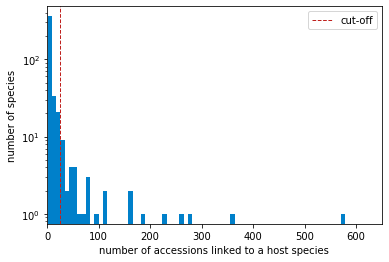

In [7]:
### Species count distribution
cutoff = 25

spec, freq = np.unique(host.Species, return_counts=True)
plt.hist(freq, bins=170, color = "#0080CA")
plt.ylabel('number of species')
plt.xlabel('number of accessions linked to a host species')
#plt.title("Abundance of PhaLP entries linked to individual host species")
plt.axvline(x=cutoff, linestyle='--', c='#bf211e', lw=1, label="cut-off")
plt.legend(loc="upper right")
plt.xlim((0,650))
plt.yscale('log')
spec = list(spec)
freq = list(freq)
print("Of the", len(spec), "taxonomic species", len([i for i in freq if i > cutoff]), "have more than {} related accessions.".format(cutoff))
plt.savefig("host_counts_hist.eps", format="eps", dpi=600)

In [8]:
### drop low-abundance data
usable_hosts = [i for idx, i in enumerate(spec) if freq[idx] > cutoff]
drop_idxs = [i for i in host.index if host.loc[i]['Species'] not in usable_hosts]
features = features.drop(drop_idxs, axis=0)
host = host.drop(drop_idxs, axis=0)

print(len(host), len(features))

5052 5052


In [9]:
usable_hosts

['Acinetobacter baumannii',
 'Aeromonas salmonicida',
 'Arthrobacter globiformis',
 'Arthrobacter sp. ATCC 21022',
 'Bacillus cereus',
 'Bacillus subtilis',
 'Bacillus thuringiensis',
 'Cutibacterium acnes',
 'Enterococcus faecalis',
 'Erwinia amylovora',
 'Escherichia coli',
 'Gordonia terrae',
 'Klebsiella pneumoniae',
 'Lactococcus lactis',
 'Listeria monocytogenes',
 'Microbacterium foliorum',
 'Mycolicibacterium smegmatis',
 'Paenibacillus larvae',
 'Pectobacterium atrosepticum',
 'Pseudomonas aeruginosa',
 'Rhodococcus erythropolis',
 'Salmonella enterica',
 'Shigella flexneri',
 'Staphylococcus aureus',
 'Streptococcus agalactiae',
 'Streptococcus dysgalactiae',
 'Streptococcus pneumoniae',
 'Streptococcus pyogenes',
 'Streptococcus suis',
 'Streptomyces griseus',
 'Synechococcus sp.',
 'Synechococcus sp. WH 7803',
 'Vibrio breoganii',
 'Vibrio cholerae',
 'Vibrio cyclitrophicus',
 'Vibrio lentus']

# Model

In [42]:
### Set hierarchy in Newick notation
newick_tree = '('
phyla = np.unique(host.Phylum)
for i in phyla:
    classes = list(np.unique(host.Class[host.Phylum == i]))
    newick_tree += '('
    for j in classes:
        orders = list(np.unique(host.Order[host.Class == j]))
        newick_tree += '('
        for k in orders:
            families = list(np.unique(host.Family[host.Order == k]))
            newick_tree += '('
            for l in families:
                genera = list(np.unique(host.Genus[host.Family == l]))
                newick_tree += '('
                for m in genera:
                    species = list(np.unique(host.Species[host.Genus == m]))
                    newick_tree +=  '(' + species[0]
                    species.pop(0)
                    for n in species:
                        newick_tree +=  ',' + n
                    newick_tree +=')' + m + ','
                newick_tree = newick_tree[:-1]
                newick_tree += ')' + l + ','
            newick_tree = newick_tree[:-1]
            newick_tree += ')' + k + ','
        newick_tree = newick_tree[:-1]
        newick_tree += ')' + j + ','
    newick_tree = newick_tree[:-1]
    newick_tree += ')' + i + ','
newick_tree = newick_tree[:-1]
newick_tree += ');'

In [43]:
def level_specific_rules(path, level):
    """
    Uses a skope-rules classifier to find the most important domains for each splitting branch along the path 
    of a predicted host genus. For each split a new classifier will be created, trained on the entries belonging 
    to that branch.
    Input:
        - path : a string containing the taxonomy of the predicted genus in the following order: phylum - class 
                 - order - family - genus
        - level : a string denoting which taxonomic level is being looked into.
    Output:
        - unique_rules : a set of domains used uniquely in rules to predict the taxonomy specified in the path 
                         and level.
    """
    
    ### trim training dataset to the wanted branch(es)
    if level == 'Phylum':
        X = features
        y = host.Phylum
        downstream_branches = list(np.unique(host.Phylum))
        predictor = path[0]
    elif level == 'Class': 
        X = features.loc[host.index[host.Phylum == path[0]]][:]
        y = host.Class[host.Phylum == path[0]]
        downstream_branches = list(np.unique(host.Class[host.Phylum == path[0]]))
        predictor = path[1]
    elif level == 'Order':
        X = features.loc[host.index[host.Class == path[1]]][:]
        y = host.Order[host.Class == path[1]]
        downstream_branches = list(np.unique(host.Order[host.Class == path[1]]))
        predictor = path[2]
    elif level == 'Family':
        X = features.loc[host.index[host.Order == path[2]]][:]
        y = host.Family[host.Order == path[2]]
        downstream_branches = list(np.unique(host.Family[host.Order == path[2]]))
        predictor = path[3]
    elif level == 'Genus':
        X = features.loc[host.index[host.Family == path[3]]][:]
        y = host.Genus[host.Family == path[3]]
        downstream_branches = list(np.unique(host.Genus[host.Family == path[3]]))
        predictor = path[4]
    elif level == 'Species':
        X = features.loc[host.index[host.Genus == path[4]]][:]
        y = host.Species[host.Genus == path[4]]
        downstream_branches = list(np.unique(host.Species[host.Genus == path[4]]))
        predictor = path[5]
    
    ### Search for level-specific domains
    if len(downstream_branches) == 1: #check whether there is a split at this level
        unique_rules = 'no split'
    else:
        le = LabelEncoder()
        le.fit(y)
        train_l = le.transform(y)
        model = SkopeRules(feature_names=features.columns, precision_min=0.5, recall_min=0.5, max_depth=5)
        index = [idx for idx, i in enumerate(downstream_branches) if i == predictor]
        model.fit(X, train_l == index)
        
        unique_rules = []
        for i in model.rules_:
            f1 = 2*i[1][0]*i[1][1]/(i[1][0]+i[1][1])
            unique_rules.append((i[0], round(f1, 3)))
        
    return unique_rules

In [45]:
### Set up tree
t = Tree(newick_tree, format=1)
ts = TreeStyle()
ts.show_scale = False
ts.show_leaf_name = False
ts.optimal_scale_level = "Full"
ts.force_topology = True
ts.scale = 750
t.convert_to_ultrametric()

def rules2arch(rules):
    if rules == 'no split':
        return rules
    arch = ''
    for idx, i in enumerate(rules):
        arch += str(idx+1) + ') ' + str(i[1]) + ': '
        splitted = i[0].split(' and ')
        for j in splitted:
            div = j.split(' ')
            if '<=' in div[1]:
                if int(float(div[2])) < 1:
                    arch += '¬'
                elif int(float(div[2])) > 1:
                    arch += str(int(float(div[2]))) + '*'
            if '_and_' in div[0]:
                consec_doms = div[0].split('_and_')
                arch += '{' + consec_doms[0] + ',' + consec_doms[1]  + '}'
            else:
                arch += div[0]
            if j != splitted[-1]:
                arch += ' + '
        if i != rules[-1]:
            arch += '\n'
    return arch

def disp_all(node):
    if not node.is_leaf():
        F = TextFace(node.name, fsize=24)
        add_face_to_node(F, node, column=0, position="branch-top")
    else:
        F = TextFace(node.name, fsize=24)
        add_face_to_node(F, node, column=0, position="branch-right")
        
    if node.name in np.unique(host.Phylum):
        path = [node.name]
        ph_dom = rules2arch(level_specific_rules(path, "Phylum"))
        F = TextFace(ph_dom, fstyle="italic", fsize=14)
        add_face_to_node(F, node, column=0, position="branch-bottom")
    elif node.name in np.unique(host.Class):
        path = [np.unique(host[host.Class == node.name].Phylum)[0], node.name]
        cl_dom = rules2arch(level_specific_rules(path, "Class"))
        F = TextFace(cl_dom, fstyle="italic", fsize=14)
        add_face_to_node(F, node, column=0, position="branch-bottom")
    elif node.name in np.unique(host.Order):
        path = [np.unique(host[host.Order == node.name].Phylum)[0], 
                np.unique(host[host.Order == node.name].Class)[0], node.name]
        od_dom = rules2arch(level_specific_rules(path, "Order"))
        F = TextFace(od_dom, fstyle="italic", fsize=14)
        add_face_to_node(F, node, column=0, position="branch-bottom")
    elif node.name in np.unique(host.Family):
        path = [np.unique(host[host.Family == node.name].Phylum)[0], 
                np.unique(host[host.Family == node.name].Class)[0], 
                np.unique(host[host.Family == node.name].Order)[0], node.name]
        fm_dom = rules2arch(level_specific_rules(path, "Family"))
        F = TextFace(fm_dom, fstyle="italic", fsize=14)
        add_face_to_node(F, node, column=0, position="branch-bottom")
    elif node.name in np.unique(host.Genus):
        path = [np.unique(host[host.Genus == node.name].Phylum)[0], 
                np.unique(host[host.Genus == node.name].Class)[0], 
                np.unique(host[host.Genus == node.name].Order)[0], 
                np.unique(host[host.Genus == node.name].Family)[0], node.name]
        gn_dom = rules2arch(level_specific_rules(path, "Genus"))
        F = TextFace(gn_dom, fstyle="italic", fsize=14)
        add_face_to_node(F, node, column=0, position="branch-bottom")
    elif node.name in np.unique(host.Species):
        path = [np.unique(host[host.Species == node.name].Phylum)[0], 
                np.unique(host[host.Species == node.name].Class)[0], 
                np.unique(host[host.Species == node.name].Order)[0], 
                np.unique(host[host.Species == node.name].Family)[0], 
                np.unique(host[host.Species == node.name].Genus)[0], node.name]
        sp_dom = rules2arch(level_specific_rules(path, "Species"))
        F = TextFace(sp_dom, fstyle="italic", fsize=14)
        add_face_to_node(F, node, column=0, position="branch-bottom")
        
ts.layout_fn = disp_all
t.render("skopeRules_hostdesign.svg", tree_style=ts, dpi=600)
t.show(tree_style=ts)